This is an example of using the pandas library and python to analyze A/B testing data from a mobile game.

A/B testing is done by presenting your population randomly with the same content/item/webpage/etc. with one difference and then analyzing relevant metrics to determine if a statistically significant change is seen in one group vs. the other.

As an example of this I am using the DataCamp Project Mobile Games A/B testing data from the following link:https://www.kaggle.com/yufengsui/datacamp-project-mobile-games-a-b-testing/data

The Data is for 'Cookie Cats', a mobile puzzle game that is a connect three style game where connecting tiles of the same color of 3 or more clears them from the board.

As players progress they will encounter gates that force them to wait a certain period of time or make an in-app purchase to progress

The use of the gates is to 1. drive in app-purchases and 2. give the player an enforced break in hopes of prolonging enjoyment and retention (prevent burnout) A/B testing was done by placing a gate at level 30 (gate_30) or level 40 (gate_40)

In [1]:
#import pandas for analysis
import pandas as pd

In [7]:
#import data and look at a sample
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
#look at the info on our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
#version is the A/B test indication, we can now count how many of each version was tested
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


<AxesSubplot:>

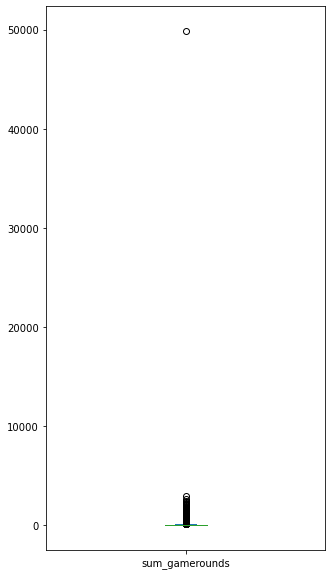

In [6]:
#analyzing player behaviour
df['sum_gamerounds'].plot.box(figsize=(5,10))

Looking at the data in a boxplot can reveal insights in the data. There is an outlier here where a player played 50,000. We can leave this outlier within the data.

In [8]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Here we can see the summary statistics of the data. We see on average players get to the 52nd game round which means that our gate_30 and gate_40 change will be relevant for the majority of players.

In [9]:
#number of players grouped by game rounds
plot_df = df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

Text(0.5, 0, 'Number of Game Rounds')

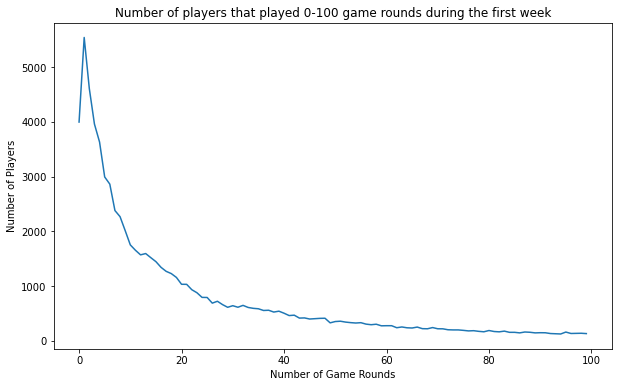

In [10]:
#plot the distribution of players over the first week
%matplotlib inline

#below plots the first 100 of the plot_df dataframe that is grouped and ordered by gamerounds
axis = plot_df[:100].plot(figsize=(10,6))
axis.set_title("Number of players that played 0-100 game rounds during the first week")
axis.set_ylabel("Number of Players")
axis.set_xlabel("Number of Game Rounds")

The data distribution is skewed with a long right tail. The drop off of players begins after the first round and plateaues around 70 games. Some players install the game but never play (0 rounds).

1-day retention is the percentage of playersthat come back and play the game one day after installing (retention_1)

In [12]:
#calculate the mean 1-day retenion
#summing retention_1 and dividing by the count will give the mean retention true=1 and false=0
df['retention_1'].sum() / df['retention_1'].count()

0.4452095044850259

44% of players return after one day after installing.

In [13]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

This shows a small difference in retention between Gate_30 and Gate_40 (0.6%), now we need to determine if this is significant. We can use bootstrapping to repeatedly resample the data with replacement to see if the difference is potentially due to variation.

<AxesSubplot:ylabel='Density'>

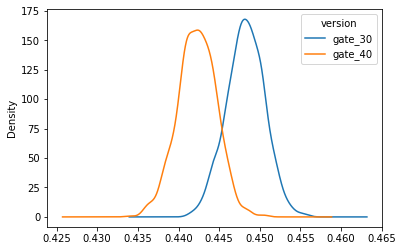

In [20]:
#empty list for bootstrap 1 day retention
bootstrap_retention_1 = []
#range is equal to number of bootstraps
for i in range(1000):
    #calculate the mean retention for each bootstrap
    bootstrap_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_1'].mean()
    #append our empty data frame with the outcome of each run
    bootstrap_retention_1.append(bootstrap_mean)
bootstrap_retention_1 = pd.DataFrame(bootstrap_retention_1)
#Kernel Density Estimate plot of the bootstrap run distribution
bootstrap_retention_1.plot(kind='density')

The two distributions show the range of uncertainty for the true 1-day retention means of each group. We can plot % difference distribution to better visualize the range of outcomes.

The probability that gate_30 has a greater 1-day retention that gate_40 is:  0.965


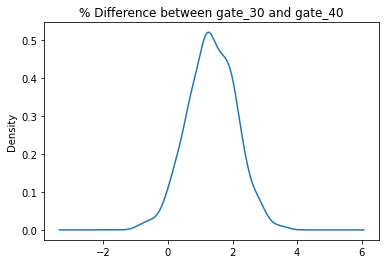

In [26]:
bootstrap_retention_1['delta'] = (bootstrap_retention_1.gate_30 - bootstrap_retention_1.gate_40)/bootstrap_retention_1.gate_40*100

axis = bootstrap_retention_1['delta'].plot(kind='density')
axis.set_title ('% Difference between gate_30 and gate_40')
print('The probability that gate_30 has a greater 1-day retention that gate_40 is: ',(bootstrap_retention_1['delta']>0).mean())

The above graph shows that 0.965 or 96.5% of the distribution is above 0 meaning that there is 96.5% probability that gate_30 has greater retention than gate_40. We can now look at the 7-day retention data. Since many players may not make it to gate 30 or 40 they may not be impacted by the differential in gate placement.

<AxesSubplot:ylabel='Density'>

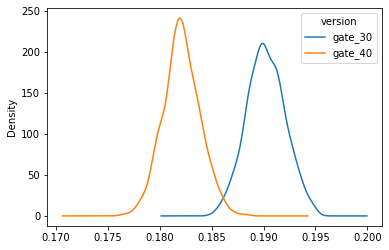

In [27]:
#Using the same method as the 1-day retention data
bootstrap_retention_7 = []
for i in range(1000):
    bootstrap_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_7'].mean()
    bootstrap_retention_7.append(bootstrap_mean)
bootstrap_retention_7 = pd.DataFrame(bootstrap_retention_7)
bootstrap_retention_7.plot(kind='density')

There is even less overlap between these two distrubtions, suggesting more certainty in a difference in 7-day retention vs the 1-day retention.

The probability that gate_30 has a greater 7-day retention that gate_40 is:  0.999


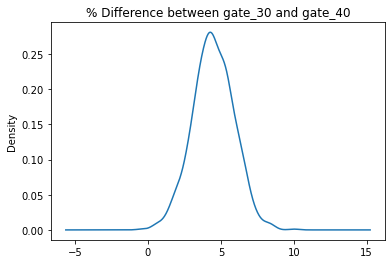

In [28]:
bootstrap_retention_7['delta'] = (bootstrap_retention_7.gate_30 - bootstrap_retention_7.gate_40)/bootstrap_retention_7.gate_40*100

axis = bootstrap_retention_7['delta'].plot(kind='density')
axis.set_title ('% Difference between gate_30 and gate_40')
print('The probability that gate_30 has a greater 7-day retention that gate_40 is: ',(bootstrap_retention_7['delta']>0).mean())

The above graph shows that 0.999 or 99.9% of the distribution is above 0 meaning that there is 99.9% probability that gate_30 has greater retention than gate_40 for 7 days. This leads to the conclusion that for greater retention for both 1 day and 7 days, a gate should be at level 30 compared to 40.

This same approach can be taken with other metrics in the game such as in-game purchases, or game time.